# Integration of DataProfiler with Synthetic Data Generator

We want to use the DataProfiler to quantify all the characteristics of the real dataset. Then we use this information as parameters for Syntthetic Data to make a synthetic dataset that mimics the real dataset. Only dealing with numeric datasets for now.

The steps are:
1. Generate a profile report with the Real Dataset
   - enable the correlation matrix and disable any unnecessary calcs
2. Map the report into `Generator` from `synthetic_data.generator_builder` to generate the Synthetic Dataset Generator
    - we now have a private dataset that mimics the real one
    - we can also tweak parameters or even add post processing
3. We can generate samples from the generator with `generator.synthesize(num_samples=...)`
  
![Workflow Diagram!](https://i.imgur.com/FYW80xO_d.webp?maxwidth=760&fidelity=grand)

In [1]:
import sys

import dataprofiler as dp
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC


sys.path.append("..")
from synthetic_data.generator_builder import Generator

## Generate DataProfiler Report

In [2]:
iris = datasets.load_iris()
data = pd.DataFrame(data=np.c_[iris["data"], iris["target"]], columns=iris["feature_names"] + ["target"])
data.target = data.target.astype(int) # 'rounding' it off to get rid of the decimal
data

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


We must enable the correlation matrix. Also disabling the data labeler to avoid a performance hit.

In [3]:
profile_options = dp.ProfilerOptions()
profile_options.set({
    "data_labeler.is_enabled": False,
    "correlation.is_enabled": True,
})

profile = dp.Profiler(data, options=profile_options)

INFO:DataProfiler.profilers.profile_builder: Finding the Null values in the columns...  (with 5 processes)
INFO:DataProfiler.profilers.profile_builder: Processing Column 1/5
INFO:DataProfiler.profilers.profile_builder: Processing Column 2/5
INFO:DataProfiler.profilers.profile_builder: Processing Column 3/5
INFO:DataProfiler.profilers.profile_builder: Processing Column 4/5
INFO:DataProfiler.profilers.profile_builder: Processing Column 5/5
INFO:DataProfiler.profilers.profile_builder: Calculating the statistics...  (with 4 processes)
INFO:DataProfiler.profilers.profile_builder: Processing Column 1/5
INFO:DataProfiler.profilers.profile_builder: Processing Column 2/5
INFO:DataProfiler.profilers.profile_builder: Processing Column 3/5
INFO:DataProfiler.profilers.profile_builder: Processing Column 4/5
INFO:DataProfiler.profilers.profile_builder: Processing Column 5/5


In [4]:
report = profile.report()
report

{'global_stats': {'samples_used': 150,
  'column_count': 5,
  'row_count': 150,
  'row_has_null_ratio': 0.0,
  'row_is_null_ratio': 0.0,
  'unique_row_ratio': 0.9933333333333333,
  'duplicate_row_count': 1,
  'file_type': "<class 'pandas.core.frame.DataFrame'>",
  'encoding': None,
  'correlation_matrix': array([[ 1.        , -0.11756978,  0.87175378,  0.81794113,  0.78256123],
         [-0.11756978,  1.        , -0.4284401 , -0.36612593, -0.42665756],
         [ 0.87175378, -0.4284401 ,  1.        ,  0.96286543,  0.9490347 ],
         [ 0.81794113, -0.36612593,  0.96286543,  1.        ,  0.95654733],
         [ 0.78256123, -0.42665756,  0.9490347 ,  0.95654733,  1.        ]]),
  'chi2_matrix': array([[nan, nan, nan, nan, nan],
         [nan,  1., nan,  0.,  0.],
         [nan, nan, nan, nan, nan],
         [nan,  0., nan,  1.,  0.],
         [nan,  0., nan,  0.,  1.]]),
  'profile_schema': defaultdict(list,
              {'sepal length (cm)': [0],
               'sepal width (cm)': [1

In [5]:
generator = Generator(profile=profile, seed=111)

In [6]:
x = generator.synthesize(10000)

sepal length (cm) True
0 float
sepal width (cm) True
1 float
petal length (cm) True
2 float
petal width (cm) True
3 float
target False
4 int


In [7]:
x

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,6.9,2.4,5.8,2.06,2.0
1,6.3,3.0,4.8,1.85,2.0
2,5.6,3.6,3.7,1.42,1.0
3,5.6,2.9,4.6,1.33,1.0
4,6.0,3.1,4.8,1.69,2.0
...,...,...,...,...,...
9995,6.3,3.1,4.9,1.95,1.0
9996,6.0,2.2,5.6,1.97,2.0
9997,6.6,3.0,5.7,2.22,2.0
9998,4.7,2.9,1.2,0.15,0.0


<Axes: >

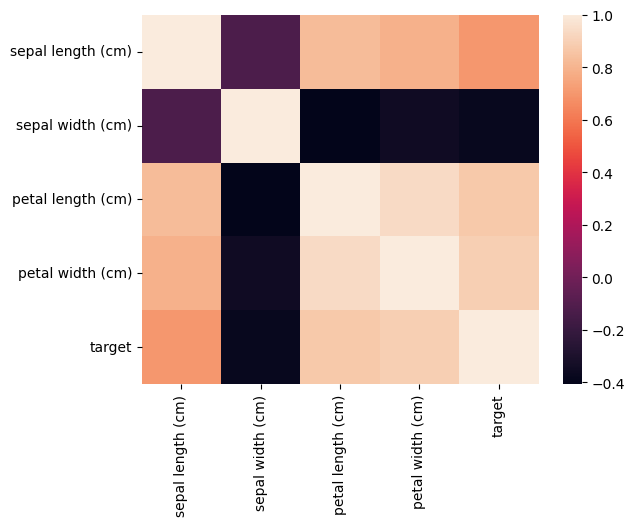

In [8]:
sns.heatmap(x.corr())

<Axes: >

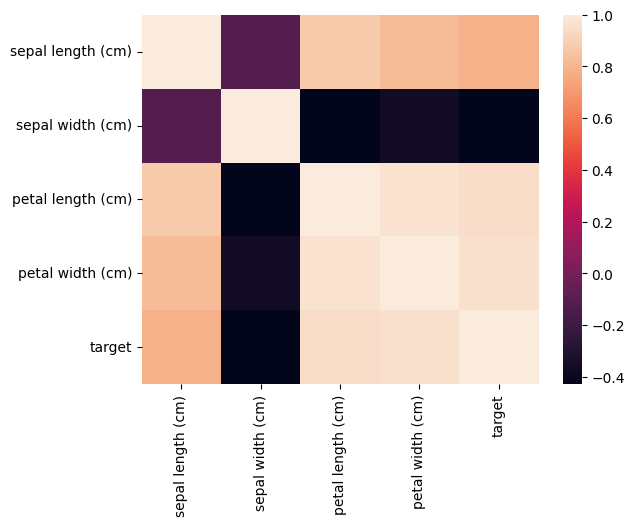

In [9]:
sns.heatmap(data.corr())

In [10]:
iris = datasets.load_iris()

training_data, test_data = train_test_split(iris.data, test_size=0.2, random_state=111)
training_target, test_target = train_test_split(iris.target, test_size=0.2, random_state=111)

clf = SVC()

clf.fit(training_data, training_target)

SVC()

In [11]:
test_results = clf.predict(test_data)
model_accuracy = list(test_results == test_target).count(True) / len(test_target)

print(f"The model was {round(model_accuracy * 100, 2)}% accurate on the authentic data")

The model was 86.67% accurate on the authentic data


In [12]:
synthetic_data = x.to_numpy()[:,:-1]
synthetic_target = x.to_numpy()[:,-1:].flatten()

synthetic_results = clf.predict(synthetic_data)
synthetic_accuracy = list(synthetic_results == synthetic_target).count(True) / len(synthetic_target)

print(f"The model was {round(synthetic_accuracy * 100, 2)}% accurate on the synthetic data")

The model was 82.7% accurate on the synthetic data


There's more work to be done with categorical variables, rounding, etc. but this is a start. Trying again below with a version of the dataset where I used one hot encoding instead.

In [13]:
Setosa = []
Versicolor = []
Virginica = []

for _, row in data.iterrows():
    if row["target"] == 0:
        Setosa.append(1)
        Versicolor.append(0)
        Virginica.append(0)
    elif row["target"] == 1:
        Setosa.append(0)
        Versicolor.append(1)
        Virginica.append(0)
    elif row["target"] == 2:
        Setosa.append(0)
        Versicolor.append(0)
        Virginica.append(1)

data = data.drop("target", axis=1)

data["Setosa"] = Setosa
data["Versicolor"] = Versicolor
data["Virginica"] = Virginica

We must enable the correlation matrix. Also disabling the data labeler to avoid a performance hit.

In [14]:
profile_options = dp.ProfilerOptions()
profile_options.set({
    "data_labeler.is_enabled": False,
    "correlation.is_enabled": True,
})

profile = dp.Profiler(data, options=profile_options)

report = profile.report()

INFO:DataProfiler.profilers.profile_builder: Finding the Null values in the columns...  (with 7 processes)
INFO:DataProfiler.profilers.profile_builder: Processing Column 1/7
INFO:DataProfiler.profilers.profile_builder: Processing Column 2/7
INFO:DataProfiler.profilers.profile_builder: Processing Column 3/7
INFO:DataProfiler.profilers.profile_builder: Processing Column 4/7
INFO:DataProfiler.profilers.profile_builder: Processing Column 5/7
INFO:DataProfiler.profilers.profile_builder: Processing Column 6/7
INFO:DataProfiler.profilers.profile_builder: Processing Column 7/7
INFO:DataProfiler.profilers.profile_builder: Calculating the statistics...  (with 4 processes)
INFO:DataProfiler.profilers.profile_builder: Processing Column 1/7
INFO:DataProfiler.profilers.profile_builder: Processing Column 2/7
INFO:DataProfiler.profilers.profile_builder: Processing Column 3/7
INFO:DataProfiler.profilers.profile_builder: Processing Column 4/7
INFO:DataProfiler.profilers.profile_builder: Processing Colum

In [15]:
generator = Generator(profile=profile, seed=111)

x = generator.synthesize(200)

sepal length (cm) True
0 float
sepal width (cm) True
1 float
petal length (cm) True
2 float
petal width (cm) True
3 float
Setosa False
4 int
Versicolor False
5 int
Virginica False
6 int


In [16]:
x

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Setosa,Versicolor,Virginica
0,7.1,3.0,5.7,2.11,0.0,1.0,0.0
1,5.9,2.9,4.7,1.79,0.0,0.0,1.0
2,6.8,3.0,5.7,1.84,0.0,0.0,1.0
3,6.1,3.1,4.5,1.31,1.0,0.0,1.0
4,6.1,2.7,4.7,1.56,0.0,1.0,0.0
...,...,...,...,...,...,...,...
195,5.7,2.9,4.8,1.58,0.0,1.0,0.0
196,7.6,3.1,6.3,2.44,0.0,0.0,1.0
197,4.9,3.4,1.3,0.39,1.0,0.0,0.0
198,7.9,3.0,6.7,2.33,0.0,1.0,1.0


<Axes: >

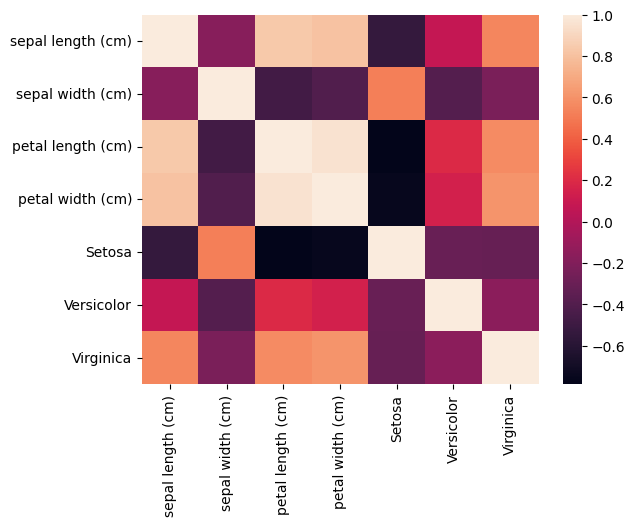

In [17]:
sns.heatmap(x.corr())

<Axes: >

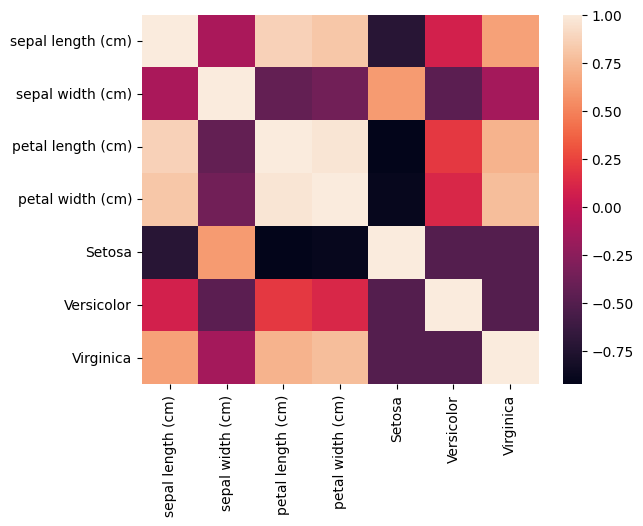

In [18]:
sns.heatmap(data.corr())